# パッケージインストール

In [ ]:
!pip install -q numpy==1.26.0
!pip install -q transformers
!pip install -q accelerate

In [2]:
# ランタイムタイプに合わせて flash_attn をインストール
# CPUは時間かかるため、GPUランタイムを推奨

import torch
import subprocess

device = 'cuda' if torch.cuda.is_available() else 'cpu'

gpu_info = None
if device == 'cuda':
    gpu_info = subprocess.check_output('nvidia-smi --query-gpu=name --format=csv,noheader', shell=True).decode('utf-8').strip()

    if 'A100' in gpu_info or 'L4' in gpu_info:
        !pip install -q flash_attn --no-build-isolation
        _attn_implementation = 'flash_attention_2'
    else:  # 'T4'
        _attn_implementation = 'eager'
else:
    _attn_implementation = 'eager'
    hardware_acceleration_type = 'CPU'

In [3]:
if gpu_info is not None:
    print(f'GPU: {gpu_info}')
print(f'device: {device}')
print(f'_attn_implementation: {_attn_implementation}')

GPU: Tesla T4
device: cuda
_attn_implementation: eager


# モデル読み込み

In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor

model_name = "microsoft/Phi-3.5-vision-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    trust_remote_code=True,
    torch_dtype="auto",
    _attn_implementation=_attn_implementation
)

# 最高のパフォーマンスを得るには、マルチフレームの場合は num_crops=4 を使用し
# シングルフレームの場合は num_crops=16 を使用
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True,
    num_crops=4
)

# サンプル画像取得

In [5]:
import requests
from PIL import Image

images = []

if device == 'cuda':
    if 'A100' in gpu_info:
        page_count = 20
    elif 'L4' in gpu_info:
        page_count = 10
    else:  # 'T4'
        page_count = 3
else:
    page_count = 1

for index in range(1, page_count+1):
    url = f"https://image.slidesharecdn.com/azureintroduction-191206101932/75/Introduction-to-Microsoft-Azure-Cloud-{index}-2048.jpg"
    images.append(Image.open(requests.get(url, stream=True).raw))

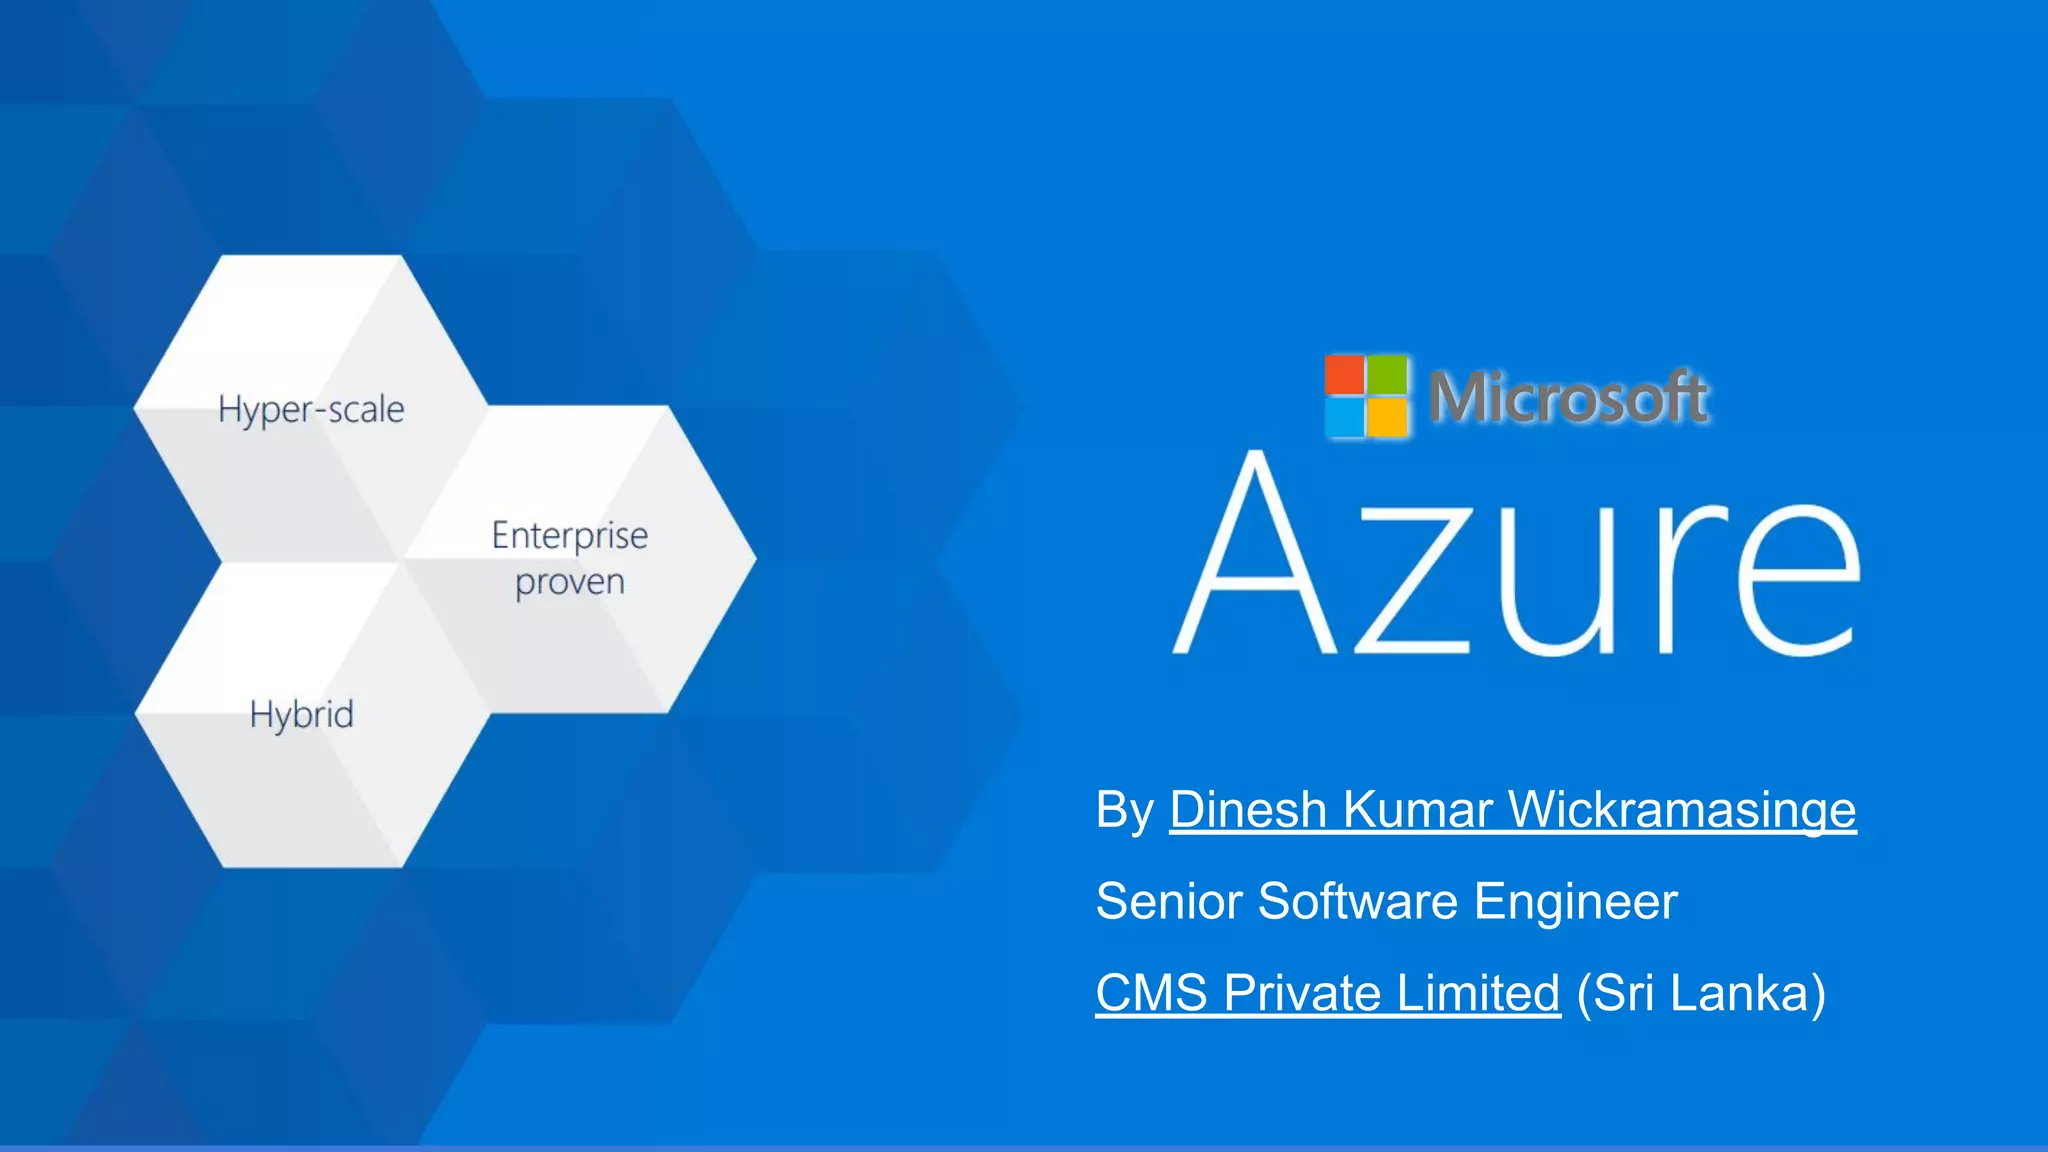

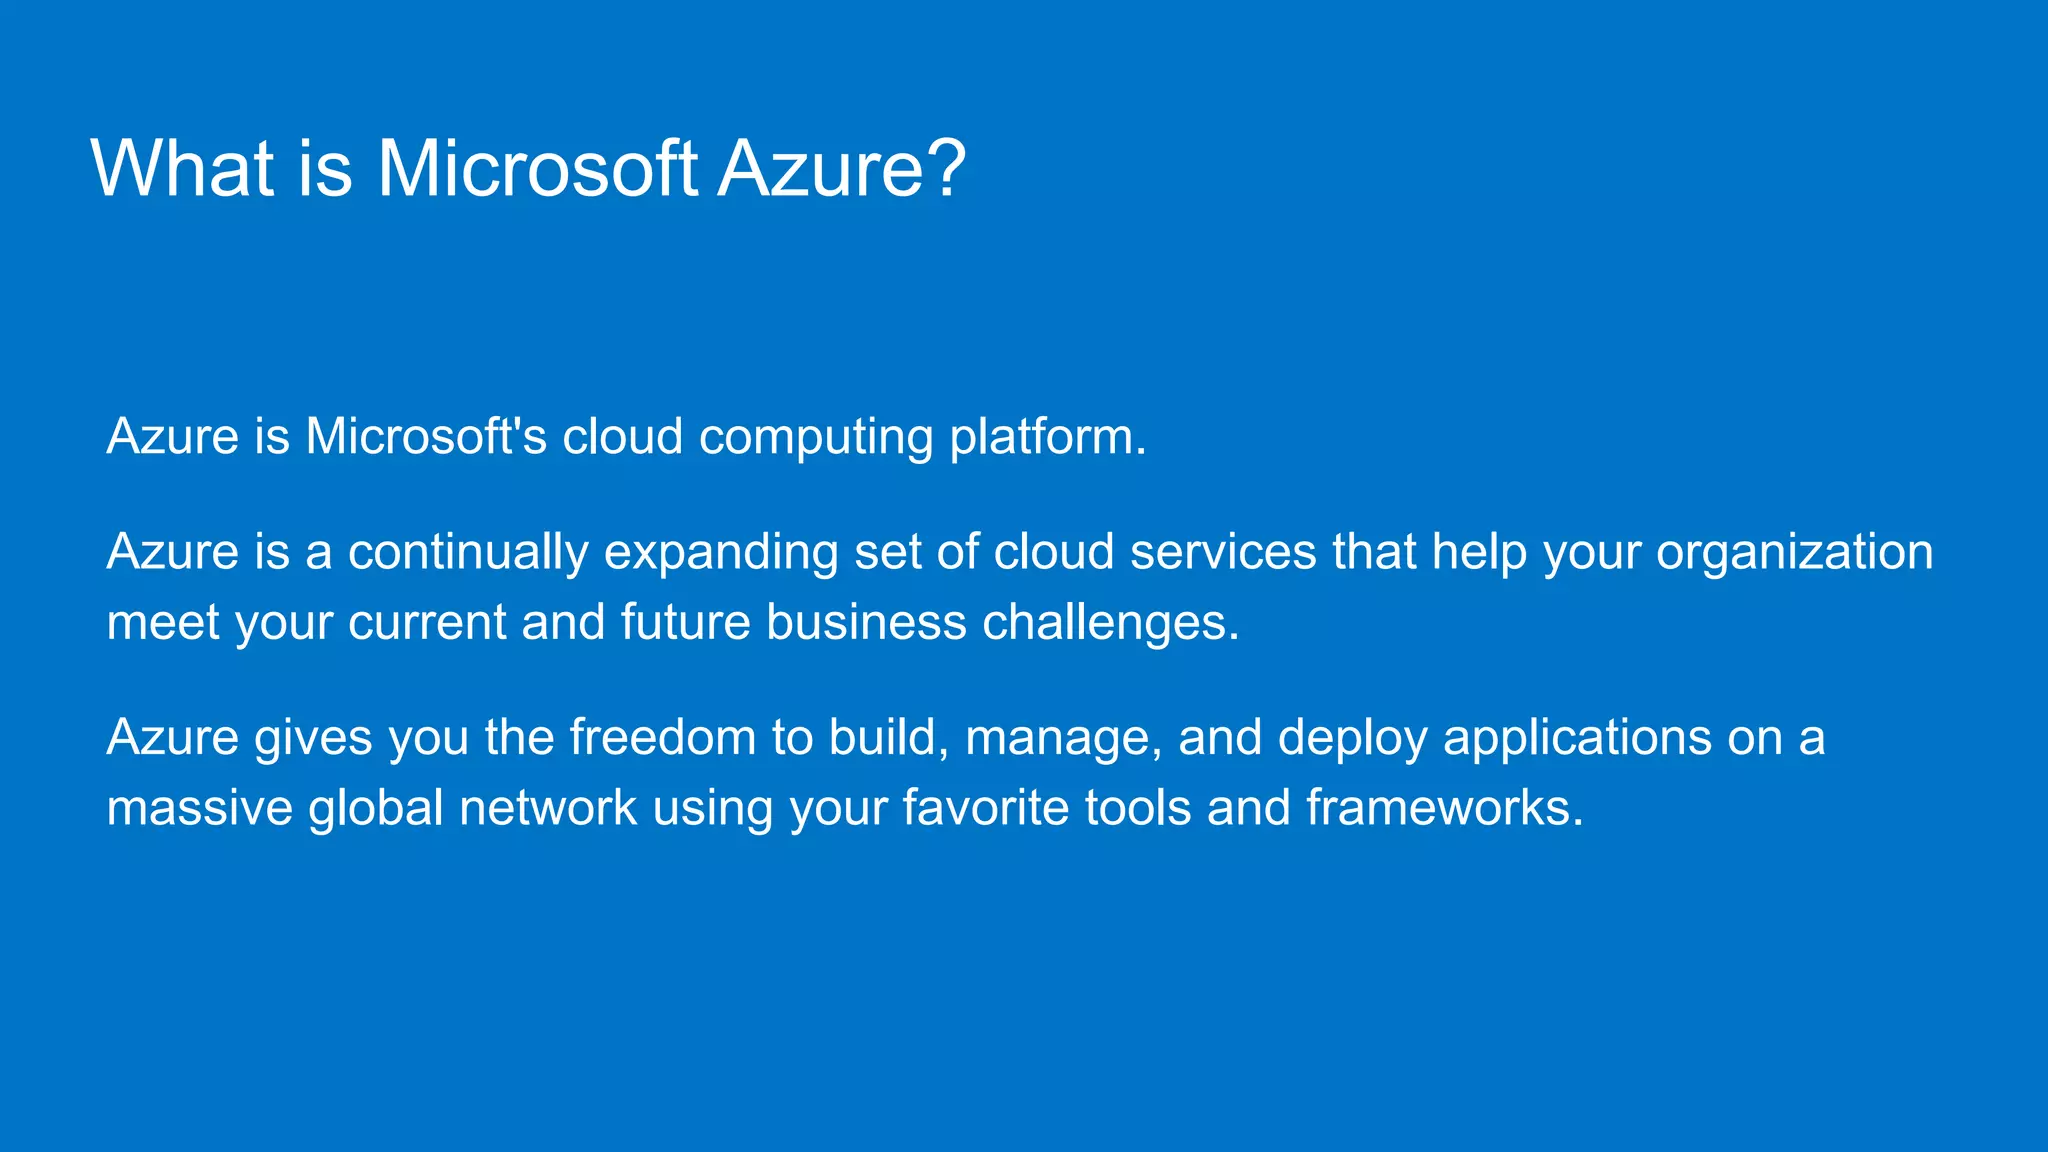

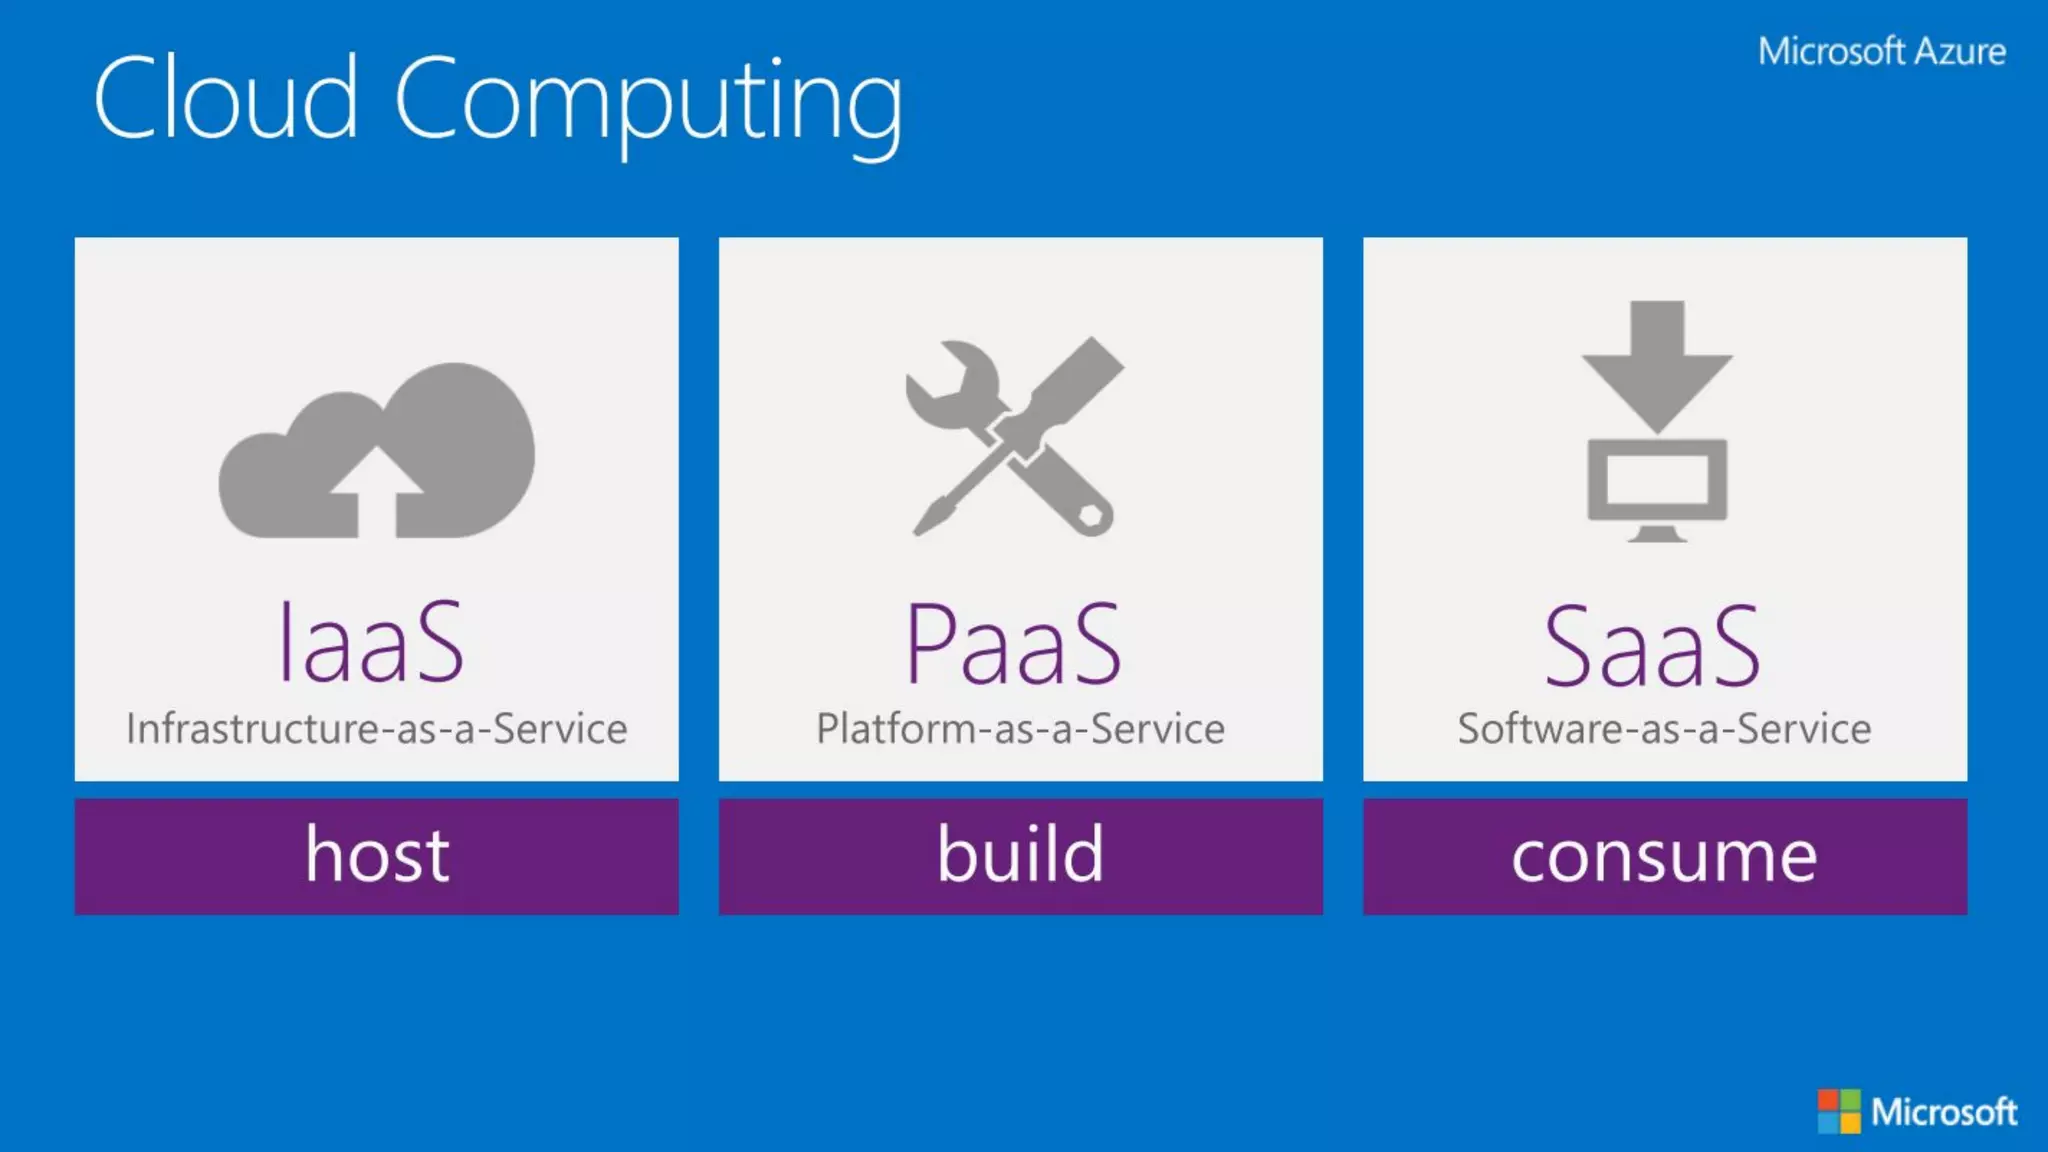

In [6]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

for image in images:
    cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    cv2_imshow(cv_image)
    print()

# 推論

In [7]:
# メッセージ生成
placeholder = ''
for index in range(len(images)):
    placeholder += f"<|image_{index+1}|>\n"
messages = [
    {"role": "user", "content": placeholder+"Summarize the deck of slides."},
]
print(messages)

[{'role': 'user', 'content': '<|image_1|>\n<|image_2|>\n<|image_3|>\nSummarize the deck of slides.'}]


In [ ]:
%%time
# プロンプト生成
prompt = processor.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

inputs = processor(prompt, images, return_tensors="pt").to(device)

generation_args = {
    "max_new_tokens": 1000,
    "temperature": 0.0,
    # "do_sample": False,
}

# 推論
generate_ids = model.generate(**inputs,
    eos_token_id=processor.tokenizer.eos_token_id,
    **generation_args
)

# 入力トークンを削除
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(
    generate_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False,
)[0]

In [9]:
print(response)

To encapsulate, the slides feature the following segments:

- Introduction: 
The presentation introduces Microsoft Azure, a cloud computing platform by Microsoft. It highlights the platform's three main types: Hyper-scale, Enterprise, and Hybrid.

- Azure Overview: 
Azure is described as a continually expanding set of cloud services that help organizations meet current and future business challenges. It offers the freedom to build, manage, and deploy applications on a massive global network using favorite tools and frameworks.

- Cloud Computing Services: 
The presentation outlines three types of cloud computing services offered by Azure: Infrastructure-as-a-Service (IaaS) with a focus on hosting, Platform-as-a-Service (PaaS) with a focus on building, and Software-as-a-Service (SaaS) with a focus on consumption.
